<div style="color:white; background-color: black; padding: 20px; border-radius:8px; font-size:26px"><b style="font-weight: 700;"><center>CAR PRICES PREDICTION</center></b></div>

<div style="background-color:  #eddcd2; padding: 10px;">

### The Data

</div>


| Column Name    | Details                                                                                                       |
|----------------|---------------------------------------------------------------------------------------------------------------|
| `model`        | Character, the model of the car, 18 possible values                                                           |
| `year`         | Numeric, year of registration from 1998 to 2020                                                               |
| `price`        | Numeric, listed value of the car in GBP                                                                       |
| `transmission` | Character, one of "Manual", "Automatic", "Semi-Auto" or "Other"                                               |
| `mileage`      | Numeric, listed mileage of the car at time of sale                                                            |
| `fuelType`     | Character, one of "Petrol", "Hybrid", "Diesel" or "Other"                                                     |
| `tax`          | Numeric, road tax in GBP. Calculated based on CO2 emissions or a fixed price depending on the age of the car. |
| `mpg`          | Numeric, miles per gallon as reported by manufacturer                                                         |
| `engineSize`   | Numeric, listed engine size, one of 16 possible values                                                        |

<div style="background-color:  #eddcd2; padding: 10px;">

### Real number Prediction Problem

</div>

**Target**: `price`


<div class="list-group" id="list-tab" role="tablist">

## TABLE OF CONTENTS

- <a href='#1'>1. IMPORTING LIBRARIES</a>
- <a href='#2'>2. READING DATA</a>
- <a href='#5'>5. BASELINE MODELS</a>
- <a href='#6'>6. HYPERPARAMETER TUNNING</a>
    - <a href='#6-1'>6.1 Using GridSearch </a>
    - <a href='#6-2'>6.2 Using OPTUNA framework </a>
</div>

# <a id='1'>1. IMPORTING LIBRARIES </a>


In [46]:
import pandas as pd
import numpy as np                          # for working with arrays and matrices

pd.set_option('display.max_rows', 500)      # Set max number of rows displayed
pd.set_option('display.max_columns', 500)   # Set max number of columns displayed
pd.set_option('display.width', 1000)

# Visualizations
import matplotlib.pyplot as plt             # for creating plots
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns
import plotly
import optuna.visualization as vis           # Visualization of Optuna framework

from scipy.stats import skew
import statsmodels.api as sm

# Save and load pkgs
import pickle

# Split pkgs
from sklearn.model_selection import train_test_split

# Preprocessing pkgs
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


# Modeling pkgs
from sklearn.linear_model import LinearRegression
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import StratifiedKFold

# Metrics pkgs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Warnings pkgs
import warnings
from sklearn.exceptions import DataConversionWarning
# Ignore DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
# Define a filter to ignore warnings with the specified prefix
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="lightgbm")


### Setting up colors preferences:
The following code customize the appearance of plots using seaborn by setting background colors and defining a custom color palette for use in the plots.

In [2]:
from matplotlib import colors

# Customize the appearance of plots: (both the axes and the figure have a background color of #FFF9ED, which is a light beige color.)
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})                              # <-- `rc` stands for "runtime configuration" and allows you to set various properties of the plot.
                                                                                                   # <-- `"axes.facecolor"` sets the background color of the plot's axes.
                                                                                                   # <-- `"figure.facecolor"` sets the background color of the entire figure.

# These colors will be used in the plots created with seaborn:
palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]


cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])   # <-- `cmap` is short for colormap, which is used for mapping data values to colors in a plot.
                                                                                                   #     This `cmap` could be used in a plot that requires a colormap (e.g., heatmap, scatter plot with color-coding).
                                                                                                   # <-- `colors.ListedColormap` is a function from the matplotlib library, which seaborn uses internally for plotting.

# <a id='2'>2. READING DATA </a>


In [3]:
# Load subsets of features choosen from Feature Selection

with open('subsets_features.pkl', 'rb') as file:
    subsets_feats = pickle.load(file)

# Unpack the combined lists into individual lists
KBest_fr_cols, KBest_mir_cols, backpval_cols, sbsLinearReg_cols, Embedded_cols, sbsGB_cols, rfeGB_cols, intersection_cols, unionGB_cols = subsets_feats

dict_subsets_feats = {'KBest_fr_cols': KBest_fr_cols,
                      'KBest_mir_cols': KBest_mir_cols,
                      'backpval_cols': backpval_cols,
                      'sbsLinearReg_cols': sbsLinearReg_cols,
                      'Embedded_cols': Embedded_cols,
                      'sbsGB_cols': sbsGB_cols,
                      'rfeGB_cols': rfeGB_cols,
                      'intersection_cols': intersection_cols,
                      'unionGB_cols': unionGB_cols}

# Loading the train and test data
X_train_scaled = pd.read_pickle('X_train_scaled')
Y_train = pd.read_pickle('Y_train')

X_test_scaled = pd.read_pickle('X_test_scaled')
Y_test = pd.read_pickle('Y_test')

After training the machine learning model, the next step is to evaluate its performance on the test set to ensure that it can generalize well to new, unseen data. This is done using evaluation metrics such as mean absolute error (MAE), mean squared error (MSE), and R-squared.


![alt text](metrics_ML_noClasif.png "Title")




Skewness-sensitive models are Linear Regression, Logistic Regression (less sensitive than linear regression and may benefit from transformation in some cases)

You need to **normalize** or **standardize** your data if you’re going to use a machine learning algorithm that does not make assumptions about the distribution of your data e.g. Linear or Logistic Regression, KNN, and Neural Networks.
The differences between these two methods are:

- **Normalization** is a scaling technique when you know your data distribution is not Gaussian (aka a bell curve/ normal distribution). Normalization is a method to adjust all your features to be on a similar scale, between 0 and 1.
- **Standardization** assumes that your data has a Gaussian (bell curve) distribution. When you apply this method, it will transform your data which will result in a distribution where the mean is 0, and the standard deviation is 1.

**MinMaxScaler**
- MinMaxScaler is part of sklearn library, and is used for **normalization**.
- This method scales the range of the feature between 0 and 1.
- This method is sensitive to outliers, so I have to handle that before applying this method.
- This method does not change the shape of your data, and only rescales it.

**StandardScaler**
- StandardScaler is part of the sklearn library and is used for **standardization**.
- It assumes that your data is normally distributed.
- This method scales the range of the feature so that the distribution is centred around 0 with a standard deviation of 1.
- This method is also sensitive to outliers, so I have to handle that before applying this method.
- This method does not change the shape of your data, and only rescales it.

# <a id='5'>5 BASELINE MODELS</a>

In [4]:
df_summ_r2 = pd.DataFrame([],
                          index = ['LinearReg', 'BayesianRidgeReg', 'RandomForestReg', 'XGBRegressor', 'GradientBoostReg', 'LGBMRegressor'],
                          columns = ['No_feeats', 'subset_feats', 'Best_R^2', 'Best_adj_R^2', 'Best_mae', 'Best_mse', 'Best_msle'])


**Function to train and test different Regression Models**

In [88]:
from sklearn.metrics import mean_squared_log_error

# Creating a function to Train and test different Regression Models
def model_evaluation(X_train, Y_train, X_test, Y_test, model, subsets_feats, model_name):

    best_r2 = 0

    for key in dict_subsets_feats:

        cols = dict_subsets_feats[key]

        model.fit(X_train[cols], Y_train)

        Y_train_pred = model.predict(X_train[cols])

        Y_test_pred = model.predict(X_test[cols])

        #Metrics Calculation.
        mae = mean_absolute_error(Y_test,Y_test_pred)                                                                          # <--- Mean Absolute Error
        mse = mean_squared_error(Y_test,Y_test_pred)                                                                           # <--- Mean Squared Error
        rmse = np.sqrt(mse)                                                                                                    # <--- Root Mean Squared Error
        r2 = r2_score(Y_test,Y_test_pred)                                                                                      # <--- R-Squared (Coefficient of Determination)
        adjusted_r2 = 1 - ((1 - r2) * (X_test[cols].shape[0] - 1) / (X_test[cols].shape[0] - X_test[cols].shape[1] - 1))       # <--- Adjusted R-Squared
        msle = -mean_squared_log_error(Y_test, Y_test_pred)                                                                    # <--- Negative Mean Squared log Error

        # Access the parameter values
        params = model.get_params()

        # Save the highest R-Squared
        if best_r2 <= r2:

            feats = key
            best_r2 = r2
            best_adj_r2 = adjusted_r2
            best_mae = mae
            best_mse = mse
            best_rmse = rmse
            best_msle = msle
            params_best = params

    print('Features selected: \n', feats)
    print()
    print(f"R2 Score of the best {model_name} model is=>",best_r2)
    print(f"Adjusted R2 Score of the best {model_name} model is=>",best_adj_r2)
    print()
    print(f"MAE of best {model_name} model is=>",best_mae)
    print(f"MSE of best {model_name} model is=>",best_mse)
    print(f"RMSE of best {model_name} model is=>",best_rmse)
    print(f"Neg_MSLE of best {model_name} model is=>",best_msle)
    print('-------------------------------------------------------------------------- \n')

    # Plots:
    plt.figure(figsize=(14,5))
    # Scatter plot.
    plt.subplot(1,2,1)
    plt.scatter(Y_train, Y_train_pred, color="#9E726F", label='Train')
    plt.scatter(Y_test, Y_test_pred, color='#F3AB60', label='Test')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.title('Scatter Plot',fontweight="black",size=20,pad=10)

    # Residual plot.
    plt.subplot(1,2,2)
    plt.scatter(Y_train_pred, Y_train_pred - Y_train, color="#9E726F", label='Train')
    plt.scatter(Y_test_pred, Y_test_pred - Y_test, color='#F3AB60', label='Test')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.title('Residual Plot',fontweight="black",size=20,pad=10)
    plt.show()

    return feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle, params_best


<p style="font-family:Georgia; font-weight:bold; letter-spacing: 1px; color:black; font-size:150%; text-align:center;padding: 0px;">1. Linear Regression Model.

Features selected: 
 intersection_cols

R2 Score of the best LinearReg model is=> 0.9568647227681024
Adjusted R2 Score of the best LinearReg model is=> 0.9558821424211343

MAE of best LinearReg model is=> 0.09534622829066589
MSE of best LinearReg model is=> 0.017463969371327638
RMSE of best LinearReg model is=> 0.1321513124086463
Neg_MSLE of best LinearReg model is=> -0.000133746568243662
-------------------------------------------------------------------------- 



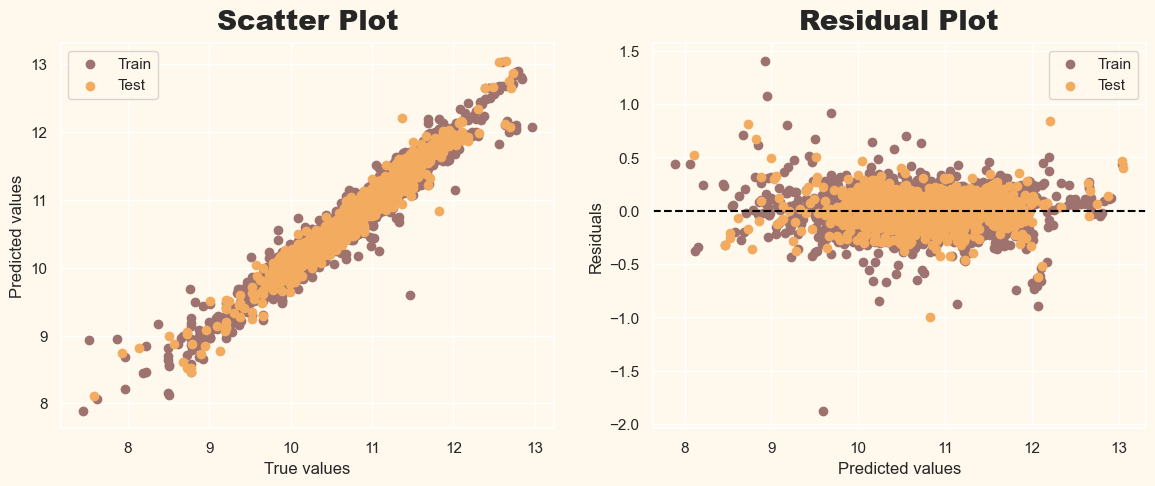

In [6]:
feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle = model_evaluation(X_train_scaled, Y_train, X_test_scaled, Y_test, LinearRegression(), subsets_feats, 'LinearReg')
df_summ_r2.loc['LinearReg'] = [len(feats), feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle]


<p style="font-family:Georgia; font-weight:bold; letter-spacing: 1px; color:black; font-size:150%; text-align:center;padding: 0px;">2. Bayesian Ridge Regression Model.

### **Bayesian Ridge Regression**

Bayesian Ridge Regression is a probabilistic approach to linear regression. It extends traditional linear regression by placing a prior distribution on the regression coefficients, which allows for uncertainty estimation in the model. It's called "Bayesian" because it applies Bayes' theorem to update the model's belief about the parameters based on the observed data.

Here's a short explanation of the main concepts:

- **Prior Distribution**: Bayesian Ridge Regression starts with a prior belief about the distribution of the regression coefficients. The most common choice is a Gaussian (Normal) distribution, which represents our belief about where the coefficients are likely to be.

- **Likelihood**: This is the probability of observing the data given the current model and parameter values.

- **Posterior Distribution**: Using Bayes' theorem, the prior and likelihood are combined to compute the posterior distribution, which represents our updated belief about the parameters after observing the data.

- **Uncertainty Estimation**: Bayesian Ridge Regression provides a way to estimate the uncertainty or confidence intervals associated with the regression coefficients.

Bayesian Ridge Regression is particularly useful when you want to capture uncertainty in your predictions, which can be crucial in certain applications like finance or medical research.

Features selected: 
 intersection_cols

R2 Score of the best BayesianRidgeReg model is=> 0.9567369078771382
Adjusted R2 Score of the best BayesianRidgeReg model is=> 0.955751416029237

MAE of best BayesianRidgeReg model is=> 0.09542330356972732
MSE of best BayesianRidgeReg model is=> 0.017515717163024858
RMSE of best BayesianRidgeReg model is=> 0.132346957513291
Neg_MSLE of best BayesianRidgeReg model is=> -0.00013428035124281423
-------------------------------------------------------------------------- 



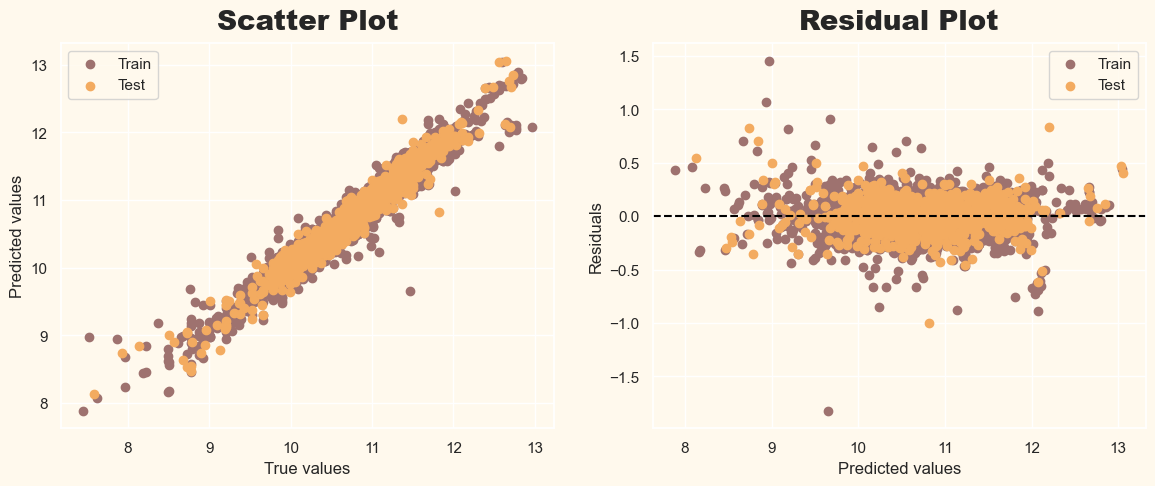

In [7]:
from sklearn.linear_model import BayesianRidge

feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle = model_evaluation(X_train_scaled, Y_train, X_test_scaled, Y_test, BayesianRidge(), subsets_feats, 'BayesianRidgeReg')
df_summ_r2.loc['BayesianRidgeReg'] = [len(feats), feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle]

<p style="font-family:Georgia; font-weight:bold; letter-spacing: 1px; color:black; font-size:150%; text-align:center;padding: 0px;">3. Random Forest Regressor.

Features selected: 
 Embedded_cols

R2 Score of the best RandomForestReg model is=> 0.9645573026975547
Adjusted R2 Score of the best RandomForestReg model is=> 0.9639688201763066

MAE of best RandomForestReg model is=> 0.08666362277330553
MSE of best RandomForestReg model is=> 0.014349512043229094
RMSE of best RandomForestReg model is=> 0.1197894487975844
Neg_MSLE of best RandomForestReg model is=> -0.00011266341216151069
-------------------------------------------------------------------------- 



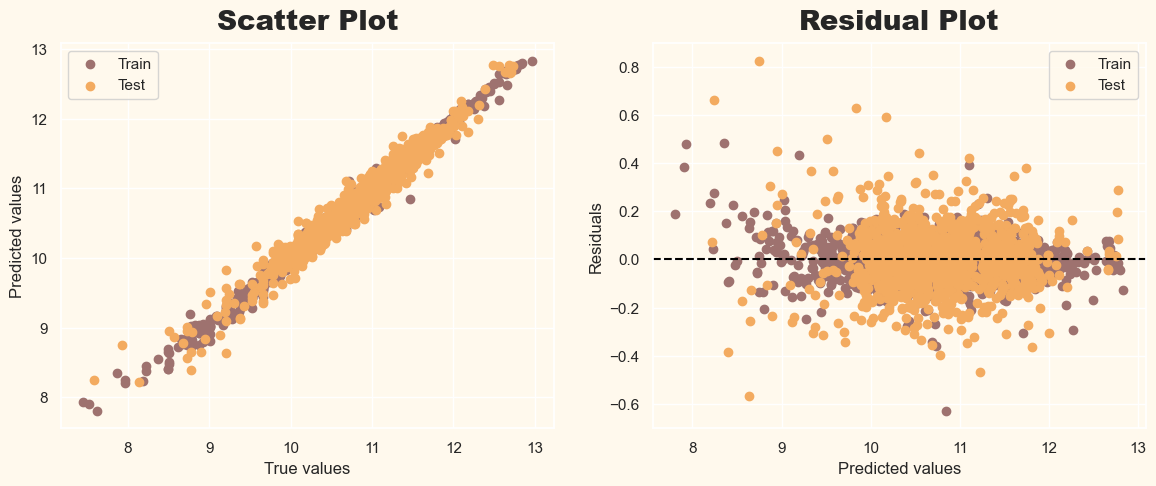

In [8]:
feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle = model_evaluation(X_train_scaled, Y_train, X_test_scaled, Y_test, RandomForestRegressor(random_state = 42), subsets_feats, 'RandomForestReg')
df_summ_r2.loc['RandomForestReg'] = [len(feats), feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle]

<p style="font-family:Georgia; font-weight:bold; letter-spacing: 1px; color:black; font-size:150%; text-align:center;padding: 0px;">4. XGBRegressor model.

Features selected: 
 sbsGB_cols

R2 Score of the best XGBRegressor model is=> 0.9668817332300712
Adjusted R2 Score of the best XGBRegressor model is=> 0.9661273307979543

MAE of best XGBRegressor model is=> 0.08299106787743407
MSE of best XGBRegressor model is=> 0.013408431187125822
RMSE of best XGBRegressor model is=> 0.1157947804830849
Neg_MSLE of best XGBRegressor model is=> -0.0001047372561651528
-------------------------------------------------------------------------- 



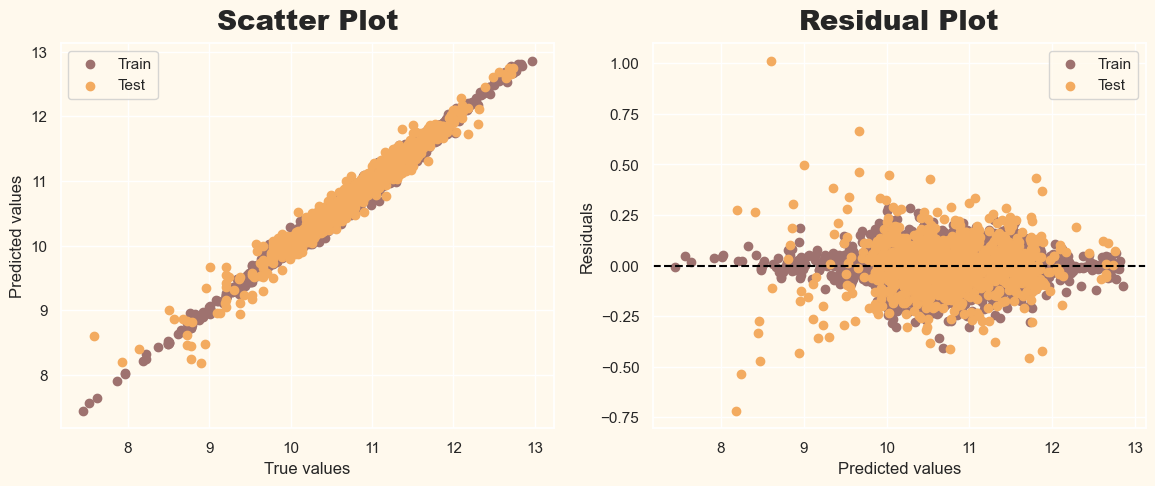

In [9]:
feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle = model_evaluation(X_train_scaled, Y_train, X_test_scaled, Y_test, XGBRegressor(random_state = 42), subsets_feats, 'XGBRegressor')
df_summ_r2.loc['XGBRegressor'] = [len(feats), feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle]

<p style="font-family:Georgia; font-weight:bold; letter-spacing: 1px; color:black; font-size:150%; text-align:center;padding: 0px;">5. Gradient Boosting Regressor.

Features selected: 
 Embedded_cols

R2 Score of the best GradientBoostReg model is=> 0.9628396402023727
Adjusted R2 Score of the best GradientBoostReg model is=> 0.9622226380019593

MAE of best GradientBoostReg model is=> 0.09196226438336269
MSE of best GradientBoostReg model is=> 0.015044933682572469
RMSE of best GradientBoostReg model is=> 0.1226577909574947
Neg_MSLE of best GradientBoostReg model is=> -0.00011607406008350302
-------------------------------------------------------------------------- 



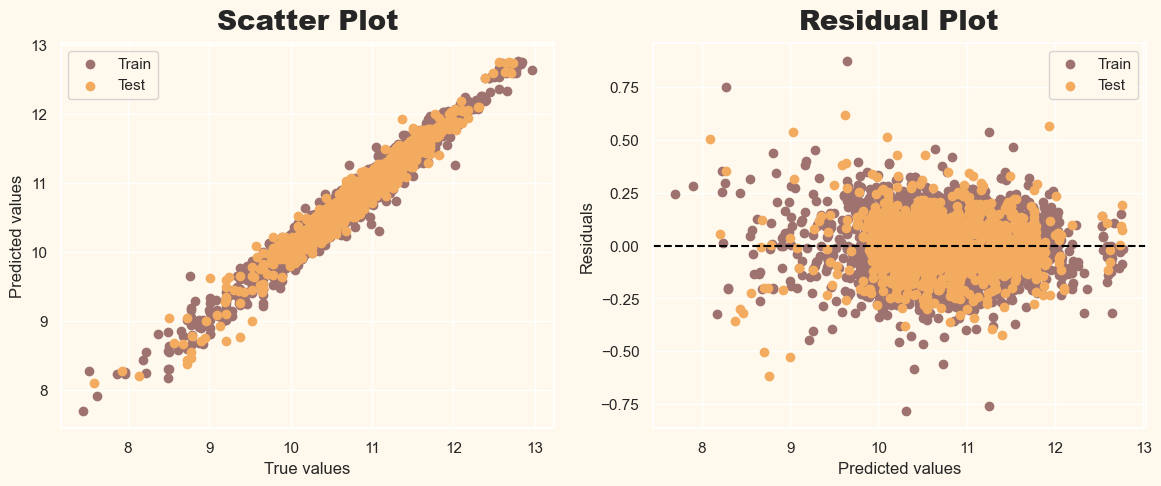

In [10]:
feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle = model_evaluation(X_train_scaled, Y_train, X_test_scaled, Y_test, GradientBoostingRegressor(random_state = 42), subsets_feats, 'GradientBoostReg')
df_summ_r2.loc['GradientBoostReg'] = [len(feats), feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle]

<p style="font-family:Georgia; font-weight:bold; letter-spacing: 1px; color:black; font-size:150%; text-align:center;padding: 0px;">6. LGBMRegressor model.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1733
[LightGBM] [Info] Number of data points in the train set: 5390, number of used features: 30
[LightGBM] [Info] Start training from score 10.707304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1733
[LightGBM] [Info] Number of data points in the train set: 5390, number of used features: 30
[LightGBM] [Info] Start training from score 10.707304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 5390, number of used features: 26
[LightGBM] [Info] Start trai

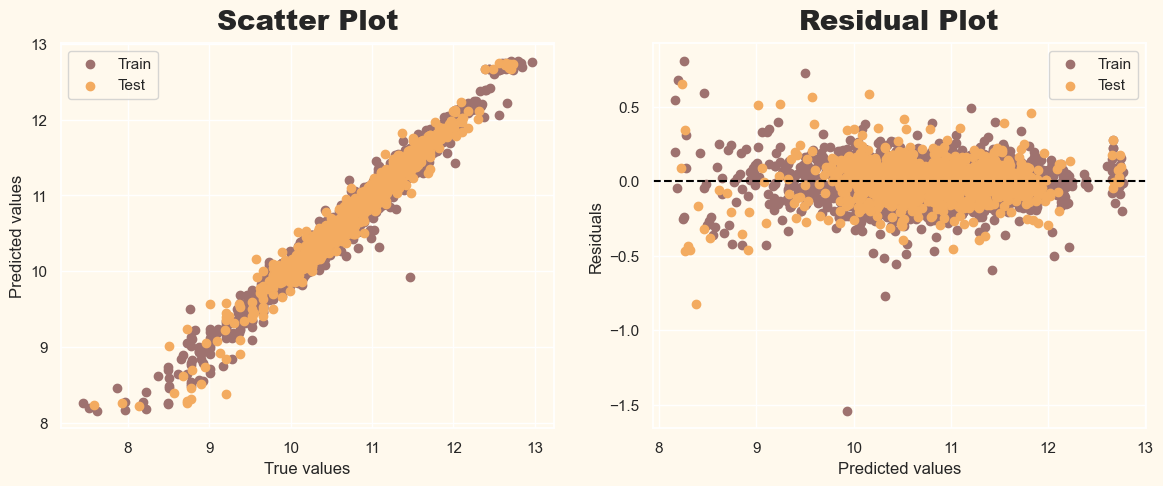

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [89]:
feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle, params_best = model_evaluation(X_train_scaled, Y_train, X_test_scaled, Y_test, LGBMRegressor(random_state = 42), subsets_feats, 'LGBMRegressor')
df_summ_r2.loc['LGBMRegressor'] = [len(feats), feats, best_r2, best_adj_r2, best_mae, best_mse, best_msle]
print(params_best)

In [12]:
from IPython.display import display

df_summ_r2

df_summ_r2 = df_summ_r2.sort_values(by = 'Best_msle', ascending = False)

display(df_summ_r2.style.background_gradient(cmap="Blues"))

# _min = df_summ_r2.values.min() #white value
# _max = df_summ_r2.values.max() #darkest blue value
#
# display(df_summ_r2.style.background_gradient(axis=None, vmin=_min, vmax=_max, cmap="Blues"))

,No_feeats,subset_feats,Best_R^2,Best_adj_R^2,Best_mae,Best_mse,Best_msle
XGBRegressor,10,sbsGB_cols,0.966882,0.966127,0.082991,0.013408,-0.000105
LGBMRegressor,12,unionGB_cols,0.967063,0.966235,0.082326,0.013335,-0.000107
RandomForestReg,13,Embedded_cols,0.964557,0.963969,0.086664,0.014350,-0.000113
GradientBoostReg,13,Embedded_cols,0.962840,0.962223,0.091962,0.015045,-0.000116
LinearReg,17,intersection_cols,0.956865,0.955882,0.095346,0.017464,-0.000134
BayesianRidgeReg,17,intersection_cols,0.956737,0.955751,0.095423,0.017516,-0.000134


# <a id='5'>6 HYPERPARAMETER TUNING</a>

Generally, **hyperparameters** of the most **tree-based models** can be grouped into 4 categories:

1. Parameters that affect the structure and learning of the decision trees
2. Parameters that affect the training speed
3. Parameters for better accuracy
4. Parameters to combat overfitting

### <a id='6-1'>6.1 USING GRID SEARCH</a>

In [ ]:
def hypertun_bestmodel(X_train, Y_train, X_test, Y_test, model, gs, model_name):

    grid_search = GridSearchCV(estimator = model,
                               param_grid = gs,
                               scoring = 'r2',
                               cv = 5,
                               n_jobs = -1)

    grid_search.fit(X_train, Y_train)

    # Best parameters found by Grid Search
    best_params = grid_search.best_params_

    print('Best parameters:', best_params)

    Y_pred_train = grid_search.predict(X_train)
    Y_pred_test = grid_search.predict(X_test)

    print('\n ---------------------------------------------------------------------')
    print("R2_Score of {}: {}".format(model_name, r2_score(Y_test,Y_pred_test)))
    print("Adjusted_R2_Score of {}: {}".format(model_name, 1-((1-r2_score(Y_test,Y_pred_test))*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))))

    print("Training RMSE for {}: {}".format(model_name, np.sqrt(mean_squared_error(Y_train, Y_pred_train))))
    print ('Test RMSE for {}: {}'.format(model_name, np.sqrt(mean_squared_error(Y_test, Y_pred_test))))



<p style="font-family:Georgia; font-weight:bold; letter-spacing: 1px; color:black; font-size:150%; text-align:center;padding: 0px;">1. Linear Regression Model.

When tuning hyperparameters for a Linear Regression model, you're primarily dealing with the regularization terms, as Linear Regression doesn't have many hyperparameters compared to complex models like tree-based algorithms. Here are the main hyperparameters you might consider:

- **Fit Intercept (`fit_intercept`)**:
    - This determines whether to calculate the intercept for this model. It's usually set to True to allow the model to find the best-fitting line.

- **Normalization (`normalize`)**:
    - If set to True, it scales the features before fitting. This can be important if the features have very different scales.

- **Regularization Type (`penalty`)**:
    - Linear Regression can be regularized to prevent overfitting. The two common types are L1 (Lasso) and L2 (Ridge) regularization.
        - L1 (Lasso): Encourages sparsity, which means it tends to push less important feature coefficients towards zero.
        - L2 (Ridge): Encourages small coefficients for all features.

- **Regularization Strength (`alpha`)**:
    - This is the strength of the regularization term. Higher values of alpha increase the regularization strength.

- **Solver (`solver`)**:
    - This determines which solver to use for fitting the model. Common choices are 'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', and 'sag'.

- **Maximum Number of Iterations (`max_iter`)**:
    - This sets the maximum number of iterations for the optimization algorithm to converge.

The most commonly tuned hyperparameters for Linear Regression are **fit_intercept**, **normalize**, **penalty**, and **alpha** for regularized variants (Lasso and Ridge).

In [ ]:
search_space_lr = {'fit_intercept':[True,False]}

hypertun_bestmodel(X_train_scaled[intersection_cols], Y_train, X_test_scaled[intersection_cols], Y_test, LinearRegression(), search_space_lr, 'Linear Regression')

<p style="font-family:Georgia; font-weight:bold; letter-spacing: 1px; color:black; font-size:150%; text-align:center;padding: 0px;">2. LGBMRegressor model.

**In LGBM, the most important parameter to control the tree structure is num_leaves.**

When tuning hyperparameters for the LGBMRegressor model, it's important to focus on the following key hyperparameters:

- **`num_leaves`**:
    - This parameter controls the maximum number of leaves in each tree. Higher values can lead to more complex models, potentially overfitting the training data. Lower values can make the model more robust but might result in underfitting. There is a simple formula given in LGBM documentation: **the maximum limit to num_leaves should be $2^{(\text{max_depth})}$**. This means the optimal value for num_leaves lies within the range ($2^3$, $2^{12}$) or (8, 4096).

- **`max_depth`**:
    - This sets the maximum depth of the individual trees. Deeper trees can capture more complex relationships in the data but are more prone to overfitting. It's recommended to limit the depth to prevent overfitting. In general, you should choose a value between 3 and 12.

- **`min_child_samples`**:
    - This parameter specifies the minimum number of samples (data points) required to create a leaf. It helps to control overfitting. Higher values will lead to a more conservative model.

- **`learning_rate`**:
    - The learning rate determines the step size at which the model adapts during training. Lower learning rates generally require more boosting rounds but can lead to better generalization.

- **`n_estimators`**:
    - This is the number of boosting rounds or trees to be used in the ensemble. Increasing the number of estimators can lead to better performance, but it also increases the risk of overfitting.

- **`subsample`**:
    - This parameter controls the fraction of samples used for fitting the trees. A value less than 1.0 introduces stochasticity, which can help reduce overfitting.

- **`colsample_bytree`**:
    - It controls the fraction of features used when fitting each tree. Similar to subsample, it introduces randomness and can help prevent overfitting.

- **`reg_alpha`** and **`reg_lambda`**:
    - These are L1 and L2 regularization terms that can be applied to the leaf weights. They help control the complexity of the model and reduce overfitting.

- **`min_child_weight`**:
    - This parameter sets the minimum sum of weights (Hessian) needed in a child (leaf) node. It can be used to control the tree's behavior.

- **`early_stopping_rounds`**:
    - This is a technique to automatically stop training once a certain evaluation metric stops improving. It helps prevent overfitting and can speed up training.

- **`objective`**:
    - This defines the loss function to be optimized during training. For regression tasks, you'd typically use 'regression', 'regression_l1', or 'huber', depending on the problem.

- **`boosting_type`**:
    - This determines the type of boosting algorithm to use. Options include gbdt, dart, goss, and rf. Each has its own characteristics and may require different tuning.

In [ ]:
search_space_lgb = {"boosting_type":['gbdt','dart','goss','rf'],
                    'learning_rate': [0.003, 0.03, 0.1, 0.3],
                    'num_leaves': [8, 20, 60, 100],
                    'max_depth': [1,3,5,7],
                    'n_estimators': [30,50,75,100]}

hypertun_bestmodel(X_train_scaled[unionGB_cols], Y_train, X_test_scaled[unionGB_cols], Y_test, LGBMRegressor(random_state = 42), search_space_lgb, 'LGBMRegressor')

### <a id='6-2'>6.2 USING OPTUNA</a>

<p style="font-family:Georgia; font-weight:bold; letter-spacing: 1px; color:black; font-size:150%; text-align:center;padding: 0px;">2. LGBMRegressor model.

### **Version 1**

In [92]:
from sklearn.model_selection import cross_validate
import optuna

def objective(trial, X_train_scaled, Y_train):

    # Split the train data into train and test data
    train_x, test_x, train_y, test_y = train_test_split(X_train_scaled,
                                                        Y_train,
                                                        test_size = 0.2,
                                                        random_state = 42)

    # Define the search space of parameters grid
    search_space_lgb = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 500, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5,0.6,0.7,0.8,0.9, 1.0]),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        # "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 50, step=2),                                                     # <--- Or `reg_lambda`. This parameter controls the L2 regularization term (Ridge). L2 regularization adds the squared values of the coefficients to the loss function, which penalizes large coefficients. It helps to prevent overfitting and can also be useful for handling multicollinearity. Higher values of lambda_l2 increase the strength of L2 regularization.
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300)
        # "n_iter_no_change": 50,  # early stopping
    }

    # Instantiate the model with the parameters from the parameters grid
    model = LGBMRegressor(**search_space_lgb, early_stopping_rounds = 50, verbosity = 1)

    # Fit the model to the new train data
    model.fit(train_x,
              train_y,
              eval_set = [(test_x, test_y)]
              )

    # Make predictions for the new test data
    Y_preds = model.predict(test_x)

    # Compute MSE
    rmse = mean_squared_error(test_y, Y_preds, squared = False)

    return rmse

In [93]:
%%time

# Create study that minimizes
study = optuna.create_study(direction='minimize')      # <---  Since the objective of the fuction is to minimize the RMSE

# Pass additional arguments inside another function
func = lambda trial: objective(trial, X_train_scaled[unionGB_cols], Y_train)

# Start optimizing with 100 trials
study.optimize(func, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best params:', study.best_trial.params)

display(study.trials_dataframe())

[I 2023-09-26 21:30:17,434] A new study created in memory with name: no-name-ea0c8bed-24af-4a48-9507-51f2e21374e5
[I 2023-09-26 21:30:17,470] Trial 0 finished with value: 0.2819892337767796 and parameters: {'n_estimators': 100, 'learning_rate': 0.02240118959923379, 'num_leaves': 440, 'max_depth': 5, 'colsample_bytree': 0.5, 'max_bin': 248, 'lambda_l2': 36, 'min_gain_to_split': 1.0441067958582517, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.4, 'min_child_samples': 137}. Best is trial 0 with value: 0.2819892337767796.
[I 2023-09-26 21:30:17,497] Trial 1 finished with value: 0.18249132714026794 and parameters: {'n_estimators': 100, 'learning_rate': 0.26061268817174943, 'num_leaves': 480, 'max_depth': 11, 'colsample_bytree': 0.5, 'max_bin': 275, 'lambda_l2': 44, 'min_gain_to_split': 4.689111632072814, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'min_child_samples': 75}. Best is trial 1 with value: 0.18249132714026794.
[I 2023-09

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=1.0441067958582517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0441067958582517
[LightGBM] [Warning] lambda_l2 is set=36, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=1.0441067958582517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.

[I 2023-09-26 21:30:17,640] Trial 6 finished with value: 0.20639449061988127 and parameters: {'n_estimators': 100, 'learning_rate': 0.20230351042931086, 'num_leaves': 40, 'max_depth': 7, 'colsample_bytree': 0.6, 'max_bin': 242, 'lambda_l2': 0, 'min_gain_to_split': 4.5229052535665994, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'min_child_samples': 204}. Best is trial 1 with value: 0.18249132714026794.
[I 2023-09-26 21:30:17,669] Trial 7 finished with value: 0.21079750454356438 and parameters: {'n_estimators': 100, 'learning_rate': 0.07310218841477899, 'num_leaves': 80, 'max_depth': 7, 'colsample_bytree': 1.0, 'max_bin': 276, 'lambda_l2': 28, 'min_gain_to_split': 5.504970399433322, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4, 'min_child_samples': 153}. Best is trial 1 with value: 0.18249132714026794.
[I 2023-09-26 21:30:17,694] Trial 8 finished with value: 0.3335602260506627 and parameters: {'n_estimators': 100, 'learning_rate': 0.2934629

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=4.5229052535665994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5229052535665994
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=4.5229052535665994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.52

[I 2023-09-26 21:30:17,873] Trial 12 finished with value: 0.24530018308842616 and parameters: {'n_estimators': 100, 'learning_rate': 0.22994055623754617, 'num_leaves': 180, 'max_depth': 9, 'colsample_bytree': 0.9, 'max_bin': 271, 'lambda_l2': 50, 'min_gain_to_split': 14.821947062240564, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_samples': 4}. Best is trial 9 with value: 0.16124482980329238.
[I 2023-09-26 21:30:17,941] Trial 13 finished with value: 0.17998002328014573 and parameters: {'n_estimators': 100, 'learning_rate': 0.15749292817665847, 'num_leaves': 140, 'max_depth': 10, 'colsample_bytree': 0.7, 'max_bin': 293, 'lambda_l2': 50, 'min_gain_to_split': 2.371693418983546, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7, 'min_child_samples': 54}. Best is trial 9 with value: 0.16124482980329238.
[I 2023-09-26 21:30:18,008] Trial 14 finished with value: 0.140025190192047 and parameters: {'n_estimators': 100, 'learnin

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.821947062240564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.821947062240564
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.821947062240564, min_split_gain=0.0 will be ignored. Curre

[I 2023-09-26 21:30:18,058] Trial 15 finished with value: 0.20303427741577929 and parameters: {'n_estimators': 100, 'learning_rate': 0.2970341826569261, 'num_leaves': 260, 'max_depth': 9, 'colsample_bytree': 1.0, 'max_bin': 260, 'lambda_l2': 12, 'min_gain_to_split': 0.17208908109100562, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'min_child_samples': 295}. Best is trial 14 with value: 0.140025190192047.
[I 2023-09-26 21:30:18,119] Trial 16 finished with value: 0.1574269586000884 and parameters: {'n_estimators': 100, 'learning_rate': 0.1913838980884311, 'num_leaves': 280, 'max_depth': 9, 'colsample_bytree': 0.9, 'max_bin': 286, 'lambda_l2': 10, 'min_gain_to_split': 2.7086708740423524, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'min_child_samples': 36}. Best is trial 14 with value: 0.140025190192047.
[I 2023-09-26 21:30:18,177] Trial 17 finished with value: 0.1644311291349034 and parameters: {'n_estimators'

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.7086708740423524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7086708740423524
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.7086708740423524, min_split_g

[I 2023-09-26 21:30:18,313] Trial 19 finished with value: 0.18552782064836254 and parameters: {'n_estimators': 100, 'learning_rate': 0.24044343079309022, 'num_leaves': 300, 'max_depth': 8, 'colsample_bytree': 0.9, 'max_bin': 284, 'lambda_l2': 18, 'min_gain_to_split': 0.022134026292863818, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5, 'min_child_samples': 184}. Best is trial 14 with value: 0.140025190192047.
[I 2023-09-26 21:30:18,379] Trial 20 finished with value: 0.21495179781417847 and parameters: {'n_estimators': 100, 'learning_rate': 0.2697871108489515, 'num_leaves': 420, 'max_depth': 5, 'colsample_bytree': 0.7, 'max_bin': 215, 'lambda_l2': 6, 'min_gain_to_split': 1.2516682285964114, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_samples': 255}. Best is trial 14 with value: 0.140025190192047.
[I 2023-09-26 21:30:18,441] Trial 21 finished with value: 0.16828357512070158 and parameters: {'n_estimators': 100, 'learning_rate': 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0344206
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.9 will be ignored. Current v

[I 2023-09-26 21:30:18,494] Trial 22 finished with value: 0.17295014111434076 and parameters: {'n_estimators': 100, 'learning_rate': 0.22622267060270312, 'num_leaves': 300, 'max_depth': 8, 'colsample_bytree': 0.9, 'max_bin': 300, 'lambda_l2': 8, 'min_gain_to_split': 1.2678380519173744, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5, 'min_child_samples': 104}. Best is trial 14 with value: 0.140025190192047.
[I 2023-09-26 21:30:18,547] Trial 23 finished with value: 0.16355787155168822 and parameters: {'n_estimators': 100, 'learning_rate': 0.17616482831749142, 'num_leaves': 220, 'max_depth': 9, 'colsample_bytree': 0.9, 'max_bin': 265, 'lambda_l2': 18, 'min_gain_to_split': 3.327677624878422, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'min_child_samples': 34}. Best is trial 14 with value: 0.140025190192047.
[I 2023-09-26 21:30:18,598] Trial 24 finished with value: 0.1325663299174189 and parameters: {'n_estimators': 100, 'learning

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.327677624878422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.327677624878422
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.327677624878422, min_split_gain

[I 2023-09-26 21:30:18,734] Trial 26 finished with value: 0.1611425772512063 and parameters: {'n_estimators': 100, 'learning_rate': 0.24165872807210415, 'num_leaves': 400, 'max_depth': 12, 'colsample_bytree': 0.9, 'max_bin': 278, 'lambda_l2': 24, 'min_gain_to_split': 1.453892499789496, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'min_child_samples': 13}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:18,792] Trial 27 finished with value: 0.19096692313434643 and parameters: {'n_estimators': 100, 'learning_rate': 0.21852610505892417, 'num_leaves': 320, 'max_depth': 11, 'colsample_bytree': 0.9, 'max_bin': 267, 'lambda_l2': 32, 'min_gain_to_split': 4.007112174319116, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.5, 'min_child_samples': 18}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:18,852] Trial 28 finished with value: 0.1971501980823493 and parameters: {'n_estimators': 100, 'lea

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.007112174319116, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.007112174319116
[LightGBM] [Warning] lambda_l2 is set=32, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.007112174319116, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.007

[I 2023-09-26 21:30:18,969] Trial 30 finished with value: 0.14891748234442193 and parameters: {'n_estimators': 100, 'learning_rate': 0.21492828970856365, 'num_leaves': 440, 'max_depth': 11, 'colsample_bytree': 0.6, 'max_bin': 279, 'lambda_l2': 34, 'min_gain_to_split': 0.9105885972501442, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8, 'min_child_samples': 26}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:19,037] Trial 31 finished with value: 0.14424273570506846 and parameters: {'n_estimators': 100, 'learning_rate': 0.25224473477997555, 'num_leaves': 320, 'max_depth': 11, 'colsample_bytree': 0.9, 'max_bin': 292, 'lambda_l2': 16, 'min_gain_to_split': 0.06604534529639483, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5, 'min_child_samples': 90}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:19,099] Trial 32 finished with value: 0.16623268372340352 and parameters: {'n_estimators': 100, 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1871
[LightGBM] [Info] Number of data points in the train set: 4312, number of used features: 29
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.9105885972501442, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9105885972501442
[LightGBM] [Warning] lambda_l2 is set=34, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50

[I 2023-09-26 21:30:19,164] Trial 33 finished with value: 0.161172108885925 and parameters: {'n_estimators': 100, 'learning_rate': 0.26953926318819077, 'num_leaves': 220, 'max_depth': 12, 'colsample_bytree': 0.9, 'max_bin': 269, 'lambda_l2': 16, 'min_gain_to_split': 1.994364615031719, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'min_child_samples': 52}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:19,222] Trial 34 finished with value: 0.19139255156382515 and parameters: {'n_estimators': 100, 'learning_rate': 0.2796761883311285, 'num_leaves': 320, 'max_depth': 11, 'colsample_bytree': 0.5, 'max_bin': 282, 'lambda_l2': 4, 'min_gain_to_split': 0.8019916061613004, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'min_child_samples': 121}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:19,309] Trial 35 finished with value: 0.1451581404473038 and parameters: {'n_estimators': 100, 'learn

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=1.994364615031719, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.994364615031719
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 10.711373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2023-09-26 21:30:19,372] Trial 36 finished with value: 0.16985851450252912 and parameters: {'n_estimators': 100, 'learning_rate': 0.25954282981438387, 'num_leaves': 380, 'max_depth': 11, 'colsample_bytree': 0.5, 'max_bin': 274, 'lambda_l2': 26, 'min_gain_to_split': 3.251967331212645, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4, 'min_child_samples': 46}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:19,426] Trial 37 finished with value: 0.15012737929098352 and parameters: {'n_estimators': 100, 'learning_rate': 0.235977709872729, 'num_leaves': 280, 'max_depth': 10, 'colsample_bytree': 0.6, 'max_bin': 279, 'lambda_l2': 22, 'min_gain_to_split': 0.8533673631499723, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'min_child_samples': 66}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:19,486] Trial 38 finished with value: 0.2043426377587944 and parameters: {'n_estimators': 100, 'lear

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=3.251967331212645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.251967331212645
[LightGBM] [Warning] lambda_l2 is set=26, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=3.251967331212645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.251

[I 2023-09-26 21:30:19,544] Trial 39 finished with value: 0.14608926463329638 and parameters: {'n_estimators': 100, 'learning_rate': 0.20263202946657582, 'num_leaves': 320, 'max_depth': 11, 'colsample_bytree': 0.8, 'max_bin': 299, 'lambda_l2': 40, 'min_gain_to_split': 0.6965700512029318, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5, 'min_child_samples': 27}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:19,597] Trial 40 finished with value: 0.18047757970768377 and parameters: {'n_estimators': 100, 'learning_rate': 0.28378852135766264, 'num_leaves': 460, 'max_depth': 10, 'colsample_bytree': 0.9, 'max_bin': 244, 'lambda_l2': 28, 'min_gain_to_split': 1.8277888642784157, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'min_child_samples': 79}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:19,653] Trial 41 finished with value: 0.15163383721154405 and parameters: {'n_est

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=1.8277888642784157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8277888642784157
[LightGBM] [Warning] lambda_l2 is set=28, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=1.8277888642784157, min_spl

[I 2023-09-26 21:30:19,782] Trial 43 finished with value: 0.1822172050636795 and parameters: {'n_estimators': 100, 'learning_rate': 0.24747979231848052, 'num_leaves': 360, 'max_depth': 11, 'colsample_bytree': 0.9, 'max_bin': 289, 'lambda_l2': 16, 'min_gain_to_split': 0.16171729253913156, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5, 'min_child_samples': 117}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:19,848] Trial 44 finished with value: 0.1627076809060577 and parameters: {'n_estimators': 100, 'learning_rate': 0.2299112940990492, 'num_leaves': 260, 'max_depth': 3, 'colsample_bytree': 0.9, 'max_bin': 290, 'lambda_l2': 20, 'min_gain_to_split': 1.7957524697881955, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'min_child_samples': 17}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:19,909] Trial 45 finished with value: 0.14677888793624236 and parameters: {'n_estimators': 100, 'learning_rate': 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2023-09-26 21:30:19,975] Trial 46 finished with value: 0.24468980800222112 and parameters: {'n_estimators': 100, 'learning_rate': 0.267156407037198, 'num_leaves': 280, 'max_depth': 6, 'colsample_bytree': 0.6, 'max_bin': 297, 'lambda_l2': 28, 'min_gain_to_split': 3.0559323369116576, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7, 'min_child_samples': 141}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:20,040] Trial 47 finished with value: 0.16720308609309875 and parameters: {'n_estimators': 100, 'learning_rate': 0.25183446570548823, 'num_leaves': 240, 'max_depth': 10, 'colsample_bytree': 0.9, 'max_bin': 261, 'lambda_l2': 24, 'min_gain_to_split': 2.1505803683927636, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'min_child_samples': 51}. Best is trial 25 with value: 0.13133382438914085.
[I 2023-09-26 21:30:20,109] Trial 48 finished with value: 0.16742470714585025 and parameters: {'n_estimators': 100, 'l

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=2.1505803683927636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1505803683927636
[LightGBM] [Warning] lambda_l2 is set=24, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=2.1505803683927636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_colsample_bytree,params_feature_fraction,params_lambda_l2,params_learning_rate,params_max_bin,params_max_depth,params_min_child_samples,params_min_gain_to_split,params_n_estimators,params_num_leaves,state
0,0,0.281989,2023-09-26 21:30:17.435666,2023-09-26 21:30:17.470549,0 days 00:00:00.034883,0.4,1,0.5,0.4,36,0.022401,248,5,137,1.044107,100,440,COMPLETE
1,1,0.182491,2023-09-26 21:30:17.471546,2023-09-26 21:30:17.496968,0 days 00:00:00.025422,0.9,1,0.5,0.6,44,0.260613,275,11,75,4.689112,100,480,COMPLETE
2,2,0.219344,2023-09-26 21:30:17.498962,2023-09-26 21:30:17.528862,0 days 00:00:00.029900,0.2,1,0.5,0.5,2,0.120225,232,7,103,0.210166,100,340,COMPLETE
3,3,0.280885,2023-09-26 21:30:17.529858,2023-09-26 21:30:17.553779,0 days 00:00:00.023921,0.3,1,0.6,0.4,20,0.197712,224,11,140,9.807715,100,360,COMPLETE
4,4,0.384344,2023-09-26 21:30:17.554775,2023-09-26 21:30:17.587667,0 days 00:00:00.032892,0.2,1,0.5,0.4,24,0.013411,297,12,134,3.534334,100,360,COMPLETE
5,5,0.207038,2023-09-26 21:30:17.588664,2023-09-26 21:30:17.618074,0 days 00:00:00.029410,0.8,1,0.8,0.2,30,0.108400,248,8,76,10.848019,100,360,COMPLETE
6,6,0.206394,2023-09-26 21:30:17.620066,2023-09-26 21:30:17.640995,0 days 00:00:00.020929,0.9,1,0.6,0.9,0,0.202304,242,7,204,4.522905,100,40,COMPLETE
7,7,0.210798,2023-09-26 21:30:17.641992,2023-09-26 21:30:17.668902,0 days 00:00:00.026910,0.8,1,1.0,0.4,28,0.073102,276,7,153,5.504970,100,80,COMPLETE
8,8,0.333560,2023-09-26 21:30:17.669899,2023-09-26 21:30:17.694819,0 days 00:00:00.024920,0.2,1,0.8,0.2,42,0.293463,254,6,229,10.784614,100,360,COMPLETE
9,9,0.161245,2023-09-26 21:30:17.695815,2023-09-26 21:30:17.717758,0 days 00:00:00.021943,0.9,1,1.0,0.3,30,0.150666,263,10,64,1.441731,100,80,COMPLETE


CPU times: total: 24.4 s
Wall time: 2.77 s


In [94]:
tabla = study.trials_dataframe()

tabla_sorted = tabla.sort_values(by = 'value', ascending = True)

display(tabla_sorted)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_colsample_bytree,params_feature_fraction,params_lambda_l2,params_learning_rate,params_max_bin,params_max_depth,params_min_child_samples,params_min_gain_to_split,params_n_estimators,params_num_leaves,state
25,25,0.131334,2023-09-26 21:30:18.599417,2023-09-26 21:30:18.658222,0 days 00:00:00.058805,0.6,1,0.9,0.5,24,0.223944,279,12,4,0.137967,100,320,COMPLETE
24,24,0.132566,2023-09-26 21:30:18.548078,2023-09-26 21:30:18.598421,0 days 00:00:00.050343,0.7,1,0.9,0.5,24,0.218235,283,11,24,0.140470,100,300,COMPLETE
14,14,0.140025,2023-09-26 21:30:17.942032,2023-09-26 21:30:18.008321,0 days 00:00:00.066289,0.7,1,0.9,0.6,12,0.248720,264,9,41,0.203850,100,240,COMPLETE
31,31,0.144243,2023-09-26 21:30:18.970714,2023-09-26 21:30:19.037005,0 days 00:00:00.066291,0.7,1,0.9,0.5,16,0.252245,292,11,90,0.066045,100,320,COMPLETE
35,35,0.145158,2023-09-26 21:30:19.223405,2023-09-26 21:30:19.309629,0 days 00:00:00.086224,0.6,1,0.9,0.5,20,0.248750,294,12,77,0.033943,100,340,COMPLETE
39,39,0.146089,2023-09-26 21:30:19.487547,2023-09-26 21:30:19.543869,0 days 00:00:00.056322,0.6,1,0.8,0.5,40,0.202632,299,11,27,0.696570,100,320,COMPLETE
18,18,0.146377,2023-09-26 21:30:18.178265,2023-09-26 21:30:18.244554,0 days 00:00:00.066289,0.7,1,0.9,0.5,18,0.187346,286,8,107,0.011056,100,300,COMPLETE
45,45,0.146779,2023-09-26 21:30:19.849379,2023-09-26 21:30:19.909689,0 days 00:00:00.060310,0.6,1,0.5,0.5,14,0.286348,275,12,1,0.902824,100,380,COMPLETE
30,30,0.148917,2023-09-26 21:30:18.911911,2023-09-26 21:30:18.968721,0 days 00:00:00.056810,0.6,1,0.6,0.8,34,0.214928,279,11,26,0.910589,100,440,COMPLETE
37,37,0.150127,2023-09-26 21:30:19.373415,2023-09-26 21:30:19.426749,0 days 00:00:00.053334,0.9,1,0.6,0.6,22,0.235978,279,10,66,0.853367,100,280,COMPLETE


**VISUALIZATION FOR HYPERPARAMETERS OPTIMIZATION ANALYSIS**

**Optimization History Plot**

The Optimization History Plot in Optuna provides a visual representation of the optimization process over time. It shows how the objective function value changes with each trial, allowing you to track the progress of the optimization algorithm.

Some of its components are:
- **Dots or Lines**: Each point on the plot represents the objective function value achieved by a specific trial.

- **Connecting Lines (Optional)**: Some implementations of the plot may connect the dots with lines to show the progression of the optimization process more clearly.

- **Annotations (Optional)**: Trials may be labeled with their objective function values for easy identification.

Interpreting the Optimization History Plot:

- **Trend and Progress**: Look for trends in how the objective function value changes over the course of the optimization process. Is the algorithm consistently improving the performance?

- **Convergence**: Check if the plot shows signs of convergence. A converging plot indicates that the optimization algorithm is finding better hyperparameter settings.

- **Early Stopping**: If there's an early stopping condition, it may be visible as a plateau or a leveling off of the objective function values.

- **Outliers or Anomalies**: Identify any trials that significantly deviate from the overall trend. These outliers may warrant further investigation.

- **Optimal Result**: Look for the point on the plot where the objective function value is lowest. This indicates the best performance achieved so far.

- **Comparison of Hyperparameter Configurations**: If multiple trials have similar objective function values, it may indicate that different hyperparameter settings can lead to similar performance.

The Optimization History Plot provides a dynamic visual summary of the optimization process, allowing you to quickly assess how the objective function values change over time. It helps you track progress, identify trends, and make informed decisions about the optimization strategy.

In [95]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.

fig = vis.plot_optimization_history(study)

# Set layout properties, including size
fig.update_layout(
                    width=1000,  # Set the width of the figure
                    height=600,  # Set the height of the figure
                 )

# Display the figure
fig.show()

**Parallel Coordinate Plot**

The Parallel Coordinate Plot is a visualization tool used in hyperparameter optimization to understand the relationship between multiple hyperparameters and the corresponding objective function values. It displays how different combinations of hyperparameters contribute to the performance of the model.

Components of the Parallel Coordinate Plot:

- **Vertical Axes (Hyperparameters)**: Each vertical axis represents a different hyperparameter. The axes are labeled with the names of the hyperparameters being considered.

- **Horizontal Lines (Traces)**: Each horizontal line on the plot represents a trial in the optimization process. A trial is a combination of hyperparameters and its corresponding objective function value.

- **Connecting Lines (Parallel Coordinates)**: The lines connecting the values of each hyperparameter for a specific trial are called parallel coordinates. They show the path of hyperparameter values for a given trial.

- **Objective Function Value Axis (Rightmost Axis)**: The rightmost vertical axis represents the objective function values for each trial. The values are usually scaled or normalized for better visualization.

- **Color Gradient (Optional)**: Trials can be color-coded based on their objective function values to provide additional information about the performance.

Interpreting the Parallel Coordinate Plot:

- **Patterns and Trends**: Look for patterns or trends in how the hyperparameters are set for trials with different objective function values. This can help identify regions of good and poor performance.

- **Hyperparameter Importance**: Identify which hyperparameters have the most influence on the objective function. Steeper slopes in the parallel coordinates suggest higher sensitivity.

- **Optimal Hyperparameter Combinations**: Identify the combinations of hyperparameter values that lead to the best objective function values. These can be seen as lines that tend to be higher on the plot.

- **Interactive Exploration**: Some implementations of the Parallel Coordinate Plot allow for interaction. You may be able to select specific traces to see detailed information about a particular trial.

- **Feature Engineering Insights**: If the hyperparameters correspond to features or configurations, the plot can provide insights into which combinations are most effective.

The Parallel Coordinate Plot provides a comprehensive view of how hyperparameters contribute to the performance of the model. It helps you make informed decisions about which hyperparameters to focus on for further optimization.

In [78]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = vis.plot_parallel_coordinate(study)

# Set layout properties, including size
fig.update_layout(
                    width=1500,  # Set the width of the figure
                    height=600,  # Set the height of the figure
                 )

# Display the figure
fig.show()

**Slice Plot**:

The Slice Plot in Optuna provides a visual representation of how a single hyperparameter affects the optimization process while keeping all other hyperparameters constant. It helps you understand the relationship between a specific hyperparameter and the objective function's performance

Some of its components are:

- **Slice Line**: The plot contains a single line that connects the objective function values for each value of the hyperparameter. This line helps visualize the relationship between the hyperparameter and the objective function.

- **Dots**: Each point on the slice line corresponds to a specific value of the hyperparameter and its corresponding objective function value.

- **Objective Function Values**: The values on the y-axis indicate the performance of the objective function for each value of the hyperparameter.

Interpreting the Slice Plot:

- **Trends and Patterns**: Look for trends or patterns in the slice line. For example, is there a clear increase or decrease in the objective function values as the hyperparameter changes?

- **Optimal Value**: Identify the value of the hyperparameter that leads to the best objective function performance.

- **Sensitivity**: Assess how sensitive the objective function is to changes in this particular hyperparameter. Steeper slopes indicate higher sensitivity.

- **Ranges of Interest**: Identify ranges of the hyperparameter values where the objective function performs particularly well or poorly.

- **Optimization Insights**: Use the Slice Plot to gain insights into which range of the hyperparameter might be most critical for optimization.

The Slice Plot provides a focused view of the relationship between a specific hyperparameter and the objective function. It helps you make informed decisions about how to adjust that hyperparameter for better performance.

In [79]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''

fig = vis.plot_slice(study)

# Set layout properties, including size
fig.update_layout(
                    width=2200,  # Set the width of the figure
                    height=600,  # Set the height of the figure
                 )

# Display the figure
fig.show()

**Contour Plot**

The Contour Plot in Optuna provides a visual representation of how two hyperparameters interact with each other and their impact on the optimization process. It allows you to see how the objective function varies across different combinations of two hyperparameters.

Among its components, there are:

- **Contour Lines**: The plot contains contour lines that connect points with the same objective function value. These lines help visualize the regions where the objective function has similar performance.
- **Color Gradient**: The color of the contour lines represents the objective function's value. Usually, a color gradient is used to indicate higher and lower values. For example, warmer colors (e.g., red) may represent higher values, while cooler colors (e.g., blue) represent lower values.

Interpreting the Contour Plot:

- **Peaks and Valleys**: Peaks represent regions where the objective function has higher values, while valleys represent regions with lower values. The contour lines help identify these areas.

- **Slope and Gradient**: The slope and gradient of the contour lines provide information about how the objective function changes as you vary the two hyperparameters. Steeper slopes indicate more rapid changes.

- **Optimal Region**: Look for regions with closely spaced contour lines. These regions represent areas where the objective function is relatively flat and may indicate regions of good performance.

- **Interaction Between Hyperparameters**: The Contour Plot shows how changes in one hyperparameter affect the objective function, while keeping the other hyperparameter fixed. Understanding this interaction is crucial for effective hyperparameter tuning.

The Contour Plot helps you gain insights into the behavior of the objective function with respect to pairs of hyperparameters. It can guide you in selecting combinations of hyperparameter values that lead to better performance.

In [91]:
#plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = vis.plot_contour(study, params=['num_leaves',
                                      'max_depth',
                                      'learning_rate',
                                      'colsample_bytree',
                                      'lambda_l2'])

# Set layout properties, including size
fig.update_layout(
                    width=2000,  # Set the width of the figure
                    height=1000,  # Set the height of the figure
                 )

# Display the figure
fig.show()

**Hyperparameter Importances**

The Hyperparameter Importances plot in Optuna provides a visualization of the importance of different hyperparameters in influencing the optimization process. This plot helps you understand which hyperparameters have the most significant impact on the objective function's performance.

Interpreting the Hyperparameter Importances plot:

- **Larger Bars**: Hyperparameters with longer bars have a greater influence on the optimization process. This means that changes in the values of these hyperparameters can lead to more significant improvements in the objective function.

- **Smaller Bars**: Hyperparameters with shorter bars have a relatively smaller impact on the optimization process. Changing these hyperparameters may have less effect on the objective function's performance.

- **Zero Importance**: If a hyperparameter has an importance score close to zero, it suggests that variations in this hyperparameter have little impact on the objective function's performance.

- **Negative Importance**: In some cases, a hyperparameter may have a negative importance score. This indicates that changing this hyperparameter could potentially worsen the objective function's performance.

The Hyperparameter Importances plot is valuable for identifying which hyperparameters play a crucial role in optimizing the objective function. It helps you focus your tuning efforts on the most influential hyperparameters, potentially leading to more efficient and effective hyperparameter optimization.

In [81]:
#Visualize parameter importances.
fig = vis.plot_param_importances(study)

# Set layout properties, including size
fig.update_layout(
                    width=1000,  # Set the width of the figure
                    height=600,  # Set the height of the figure
                 )

# Display the figure
fig.show()

**Empirical Distribution Function (EDF) plot**

It visualizes the empirical cumulative distribution function (ECDF) of the optimization study's objective (scores) values. The ECDF represents the proportion or count of observations falling below each unique value in a dataset.

The EDF plot is useful for visualizing how the objective values are distributed across the study. It helps you understand the range and distribution of objective values achieved during the optimization process.

Interpreting the EDF plot:

- If the plot rises steeply at low values of the objective, it indicates that many trials are achieving good results.
- If the plot rises slowly or levels off, it suggests that the optimization process may be struggling to find better results.

Overall, the EDF plot is a valuable tool for gaining insights into the progress and performance of the optimization study. It helps you assess the effectiveness of different hyperparameter configurations and make informed decisions about which hyperparameters to focus on for further tuning.

In [82]:
#Visualize empirical distribution function
fig = vis.plot_edf(study)

# Set layout properties, including size
fig.update_layout(
                    width=1000,  # Set the width of the figure
                    height=600,  # Set the height of the figure
                 )

# Display the figure
fig.show()

**LGBMRegressor MODEL WITH THE BEST HYPERPARAMETERS**

In [83]:
# Get the parameters from the best tuning
params = study.best_params
params['metric'] = 'rmse'

print(params)

{'n_estimators': 20000, 'learning_rate': 0.17504294284069563, 'num_leaves': 420, 'max_depth': 6, 'colsample_bytree': 0.6, 'max_bin': 209, 'lambda_l2': 0, 'min_gain_to_split': 0.08214504501848344, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7, 'min_child_samples': 22, 'metric': 'rmse'}


**Apply Kfold to the model with the best hyperparameters to compute the average RMSE on the test data for each of 5 folds**

In [84]:
# Apply Kfold

preds = np.zeros(X_test_scaled[unionGB_cols].shape[0])

# Instantiate the KFold object for 5-fold cross-validation. It will split data into 5 subsets (folds) for training and validation
kf = KFold(n_splits=5,
           random_state = 48,
           shuffle=True)

rmse=[]  # list contains rmse for each fold
n=0

for trn_idx, test_idx in kf.split(X_train_scaled[unionGB_cols],Y_train):                                        # <---  It iterates through the training and validation sets for each fold.

    X_tr, X_val = X_train_scaled[unionGB_cols].iloc[trn_idx], X_train_scaled[unionGB_cols].iloc[test_idx]       # <--- It assigns the training and validation data for the features (X_tr and X_val) based on the indices provided by the KFold object.

    Y_tr, Y_val = Y_train.iloc[trn_idx], Y_train.iloc[test_idx]                                                 # <--- It assigns the training and validation data for the target (Y_tr and Y_val) based on the indices provided by the KFold object.

    # Instantiate the model with the parameters from params
    model_lgbm = LGBMRegressor(**params,
                               random_state = 42,
                               early_stopping_rounds = 100,
                               verbosity = 1)

    # Train the model on the training data (X_tr, Y_tr). It also uses the validation data (X_val, Y_val) for early stopping. The mo
    model_lgbm.fit(X_tr,
                   Y_tr,
                   eval_set = [(X_val, Y_val)],)                        # <--- The model will stop training if the validation loss does not improve for 100 rounds

    # For the current fold, the model makes predictions on the test data and adds it to the 'preds' array. These predictions are divided by the number of splits (kf.n_splits) to take average prediction across all folds
    preds += model_lgbm.predict(X_test_scaled[unionGB_cols]) / kf.n_splits

    # It computes the Root Mean Squared Error (RMSE) for the current fold and appends it to the 'rmse' list
    rmse.append(mean_squared_error(Y_val, model_lgbm.predict(X_val), squared = False))

    print(n + 1, rmse[n])

    n += 1

print('\n ---------------------------------------------------------------------')
print ('Best RMSE on test data before HT: {}'.format(np.sqrt(df_summ_r2.loc['LGBMRegressor', 'Best_mse'])))
print('Average RMSE on test data: {}'.format(np.mean(rmse)))

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.08214504501848344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08214504501848344
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.08214504501848344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_spli

**Feature Importance for LGBMRegressor**

It displays the top features based on their importance scores

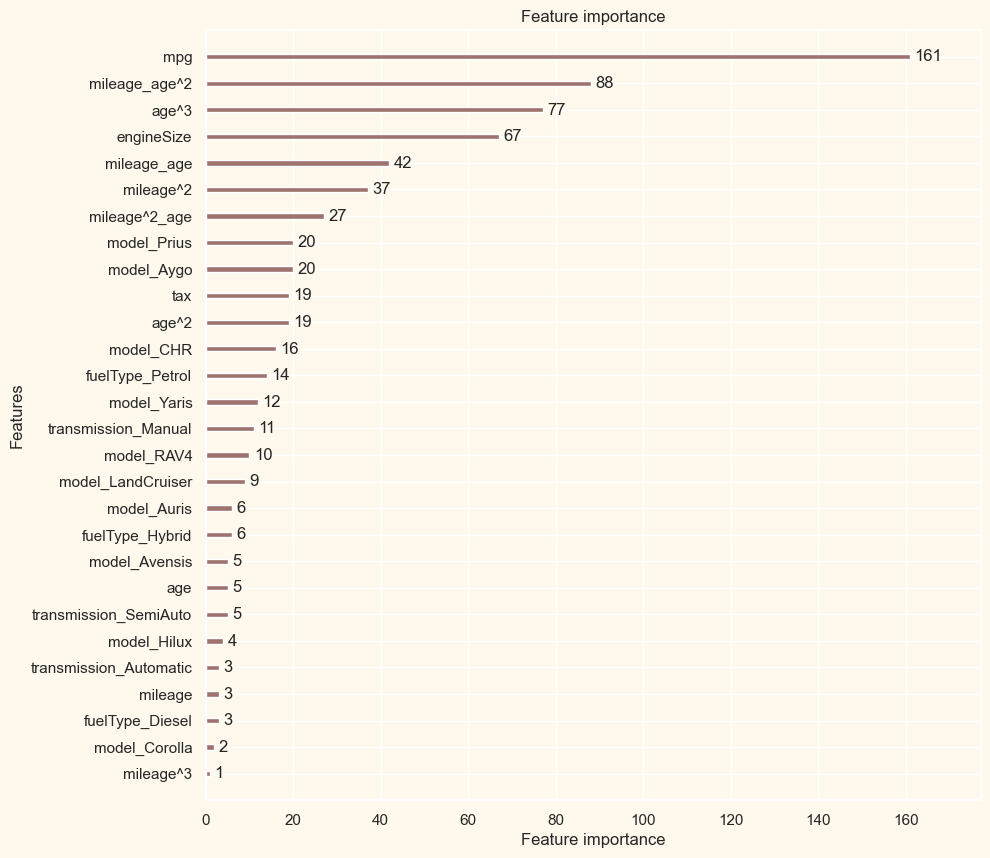

In [85]:
from optuna.integration import lightgbm as lgb

lgb.plot_importance(model_lgbm,                   # <--- previously trained model
                    max_num_features=33,          # <--- used to limited the number of features shown
                    figsize=(10,10),
                    color = "#9E726F")
plt.show()